In [1]:
import xarray as xr
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from metpy.plots import USCOUNTIES
import shapely.geometry as geom
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import numpy as np
from copy import copy
from shapely import geometry
from shapely.geometry.polygon import Polygon
import shapely.geometry as sgeom
from matplotlib.patches import Patch

### Reading in the met_em files from each domain, these files are smaller than the WRF outs and contain the needed terrain data for each domain.

#### The projection data is from the meta data within the met_em files

In [2]:
ds1 = xr.open_dataset('met_em.d01.2018-11-08_000000.nc')
lat1 = ds1.XLAT_M.squeeze()
lon1 = ds1.XLONG_M.squeeze()
ds2 = xr.open_dataset('met_em.d02.2018-11-08_000000.nc')
lat2 = ds2.XLAT_M.squeeze()
lon2 = ds2.XLONG_M.squeeze()
ds3 = xr.open_dataset('met_em.d03.2018-11-08_000000.nc')
lat3 = ds3.XLAT_M.squeeze()
lon3 = ds3.XLONG_M.squeeze()


cart_proj = ccrs.LambertConformal(central_longitude=-121.6,central_latitude=39.76,
                                  standard_parallels=(35,55))

In [3]:
def plot_background(ax): # My generic boiler plate map background.
    ax.coastlines(resolution='10m', linewidth=2, color = '#261c00', zorder = 4) ## High-res cartopy coastlines
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')               ### Natural earth feature state and country boundaries
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='#261c00', zorder =4)   ### Taking the called boundaries and adding them to the map while
    ax.add_feature(states, linestyle='-', edgecolor='#261c00',linewidth=2, zorder =4)       #  specifying the color and plot order
    ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='#261c00', linewidth=1, zorder = 1) #### Using Metpy's county shapefiles due to hi-res
                                                                                                    # and they also help with spartial awareness
    return ax


#### Below is a bit of code I found on stackoverflow.... Don't know how to commment it at this time bc I didn't write it ¯\_(ツ)_/¯
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.85, 0.05), linewidth=5,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=7, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2, fontsize = 25)
    left = x0+(x1-x0)*0.05
    up = y0+(y1+y0)*0.0089
    # Plot the N arrow
    t1 = ax.text(left, up, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2, fontsize = 25)
    # Plot the scalebar without buffer, in case covered by text buffer
    #ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
    #    linewidth=linewidth, zorder=3, edgecolor='white')

C:\Users\Matthew\Miniconda3\envs\research\lib\site-packages\ipykernel_launcher.py:13: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  del sys.path[0]
C:\Users\Matthew\Miniconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001F603713620> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
C:\Users\Matthew\Miniconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000001F677C35D00> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))
C:\Users\Matthew\Miniconda3\envs\research\lib\site-packages\ipykernel_launcher.py:112: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


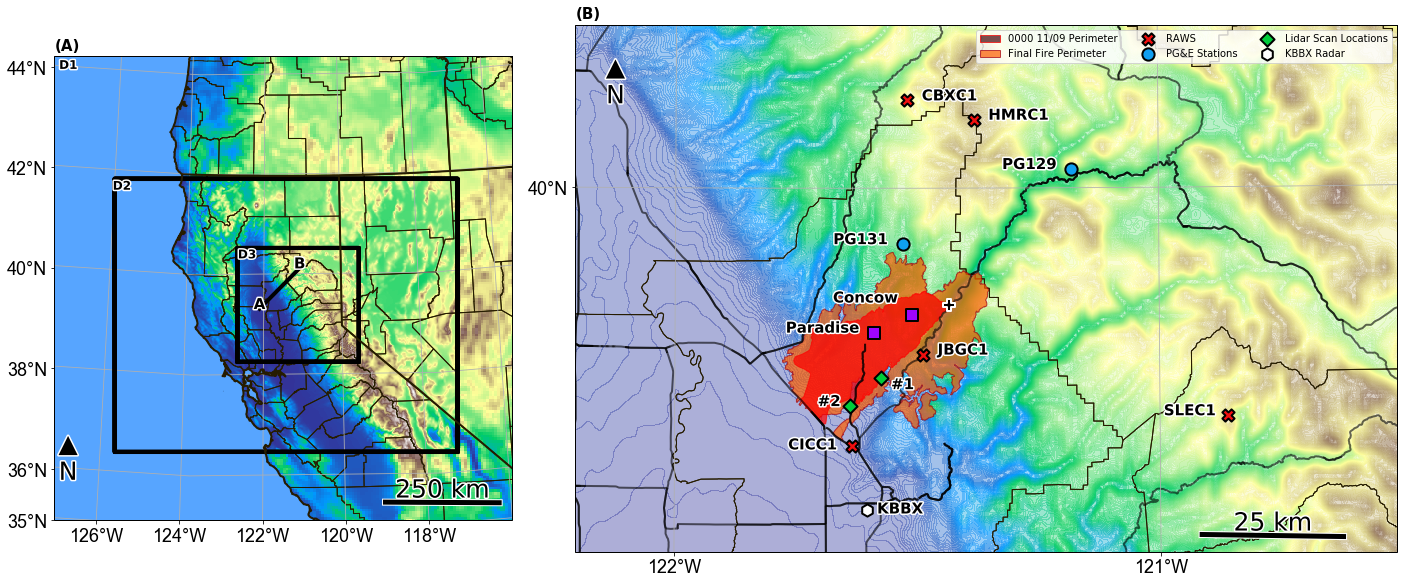

In [6]:
buffer = [patheffects.withStroke(linewidth=3, foreground="w")] ### not completely positive on how this works but from my understanding this puts the white
                                                                ## "background" behind the text in the figure
## Making the figure
fig= plt.figure(figsize = (20,8),constrained_layout=True)
gs = fig.add_gridspec(1, 3)
ax = plt.subplot(gs[0, 0] ,projection=cart_proj)

ax2 = plt.subplot(gs[0, 1:],projection=cart_proj)

ax.set_extent([-116.+360.,-127.+360., 35, 44.25], crs=ccrs.PlateCarree())
plot_background(ax)
ax.pcolormesh(lon1,lat1,ds1.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
ax.pcolormesh(lon2,lat2,ds2.HGT_M.squeeze(), transform=ccrs.PlateCarree(),cmap = 'terrain')
ax.pcolormesh(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-130,-128,-126,-124,-122,-120,-118,-116,-110, -50, -40, -30, -20, -11, 0, 10, 20, 30, 40, 50]
yticks = [10, 15, 20, 25, 30, 35,36,38, 40,42, 44, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.plot(ds2.corner_lons, ds2.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)
ax.plot(ds3.corner_lons, ds3.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
ax.text(-127.2,44,'D1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 12, fontweight = 'bold', path_effects=buffer)    
ax.text(-125.55,41.65,'D2', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 12, fontweight = 'bold', path_effects=buffer)
ax.text(-122.2,40.35,'D3', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 12, fontweight = 'bold', path_effects=buffer)
ax.plot([ -121.072881,-122.107479,], [ 40.153468,39.344559,], color='black',linewidth = 4,  transform=ccrs.PlateCarree(),  path_effects = buffer)
ax.text(-122.107, 39.34, 'A', horizontalalignment='center',transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)
ax.text(-121.07, 40.15, 'B', horizontalalignment='center',transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)
    #start_point = CoordPair(lat=39.344559, lon=-122.072881)
    #end_point = CoordPair(lat=40.153468, lon=-121.107479)
scale_bar(ax, ccrs.PlateCarree(), 250)
ocean_highres = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                                edgecolor='black',
                                                facecolor='#57a5ff',
                                                linewidth=.1
                                               )
ax.add_feature(ocean_highres)
####################################################################################   
ax2.set_extent([(ds3.corner_lons.max()-1)+360.,(ds3.corner_lons.min()+.5)+360., (ds3.corner_lats.min()+1.15), ds3.corner_lats.max()-.3], crs=ccrs.PlateCarree())
plot_background(ax2)
buffer = [patheffects.withStroke(linewidth=3, foreground="w")]



fname = r'ca_camp_20181125_1822_dd83/ca_camp_20181125_1822_dd83.shp'
final = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='#a10010', facecolor = '#ff5e00', alpha = .7)
ax2.add_feature(final,label = 'Final Perimeter')
ff= Patch(facecolor='#ff5e00', edgecolor='#a10010',
                         label='Final Perimeter', alpha = .7)
fname = r'ca_camp_20181109_0000_dd83/ca_camp_20181109_0000_dd83.shp'
camp_fireper_2 = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='red', facecolor = '#ff0000', alpha = .7)
ax2.add_feature(camp_fireper_2,label = '2nd Fire Perimeter')
f1 = Patch(facecolor='#42040b', edgecolor='r',
                         label='0000 11/09/18 Perimeter', alpha = .7)
fname = r'tl_2015_06_prisecroads/tl_2015_06_prisecroads.shp'
roads = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='black',facecolor = "None", linewidth = 2, alpha = .6)
ax2.add_feature(roads)


ax2.contourf(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(),levels = np.arange(ds3.HGT_M.min(), ds3.HGT_M.max(), 10), cmap = 'terrain', alpha = .4)

raws = ax2.scatter(-120.86,39.636, s=150,  marker = 'X', label = 'RAWS', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-120.86-.025,39.636,'SLEC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.52,40.14, s=150,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.52+.03,40.14,'CBXC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.382,40.109, s=150,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.382+.03,40.109,'HMRC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.635,39.589, s=150,  marker = 'X',  transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.635-.03,39.584,'CICC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.488,39.735, s=150,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.488+.03,39.735,'JBGC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

pge = ax2.scatter(-121.53,39.911, s=150,  marker = 'o', label = 'PG&E Station', transform = ccrs.PlateCarree(), color = '#0f9ff2',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.53-.03,39.911,'PG131', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.18,40.03, s=150,  marker = 'o',  transform = ccrs.PlateCarree(), color = '#0f9ff2',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.18-.03,40.03,'PG129', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)


ax2.scatter(-121.59,39.77, s=150,  marker = 's',  transform = ccrs.PlateCarree(), color = '#9f05ff',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.59-.03,39.77,'Paradise', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.51,39.798, s=150,  marker = 's',  transform = ccrs.PlateCarree(), color = '#9f05ff',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.51-0.03,39.798+0.02,'Concow', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)


ld = ax2.scatter(-121.574,39.697, s=100,  marker = 'D', label = 'Lidar Scan Location', transform = ccrs.PlateCarree(), color = '#00cc3a',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.574+.02,39.68,'#1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.638,39.653, s=100,  marker = 'D',  transform = ccrs.PlateCarree(), color = '#00cc3a',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.638-.02,39.653,'#2', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)


rad = ax2.scatter(-121.603,39.488, s=150,  marker = 'h', label = 'KBBX Radar', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.603+.02,39.482,'KBBX', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 15, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.4347, 39.8134, s=150,marker = 'P',  transform = ccrs.PlateCarree(), color = 'k',edgecolor= 'white', zorder = 100, linewidth =1)

ax2.legend((f1,ff,raws,pge,ld,rad), ('0000 11/09 Perimeter', 'Final Fire Perimeter', 'RAWS', 'PG&E Stations', 'Lidar Scan Locations', 'KBBX Radar'), fontsize = 'medium',ncol = 3)
scale_bar(ax2, ccrs.PlateCarree(), 25)
#ax2.text(-120.7, 40.2,u'\u25B2 \nN ', ha='center', fontsize=30, rotation = 0, transform = ccrs.PlateCarree())
fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-124,-123,-122,-121,-120,-119,-118,-117,-116,]
yticks = [35,36,37,38,39, 40,41,42, 44,]
ax2.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax2, xticks)
lambert_yticks(ax2, yticks)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);

    
ax.set_title('(A)', fontweight = 'bold', fontsize = 15, loc = 'left')
ax2.set_title('(B)', fontweight = 'bold', fontsize = 15, loc = 'left')
plt.savefig('fig1.png', dpi = 500, bbox_incehes = 'tight')

NameError: name 'buffer' is not defined

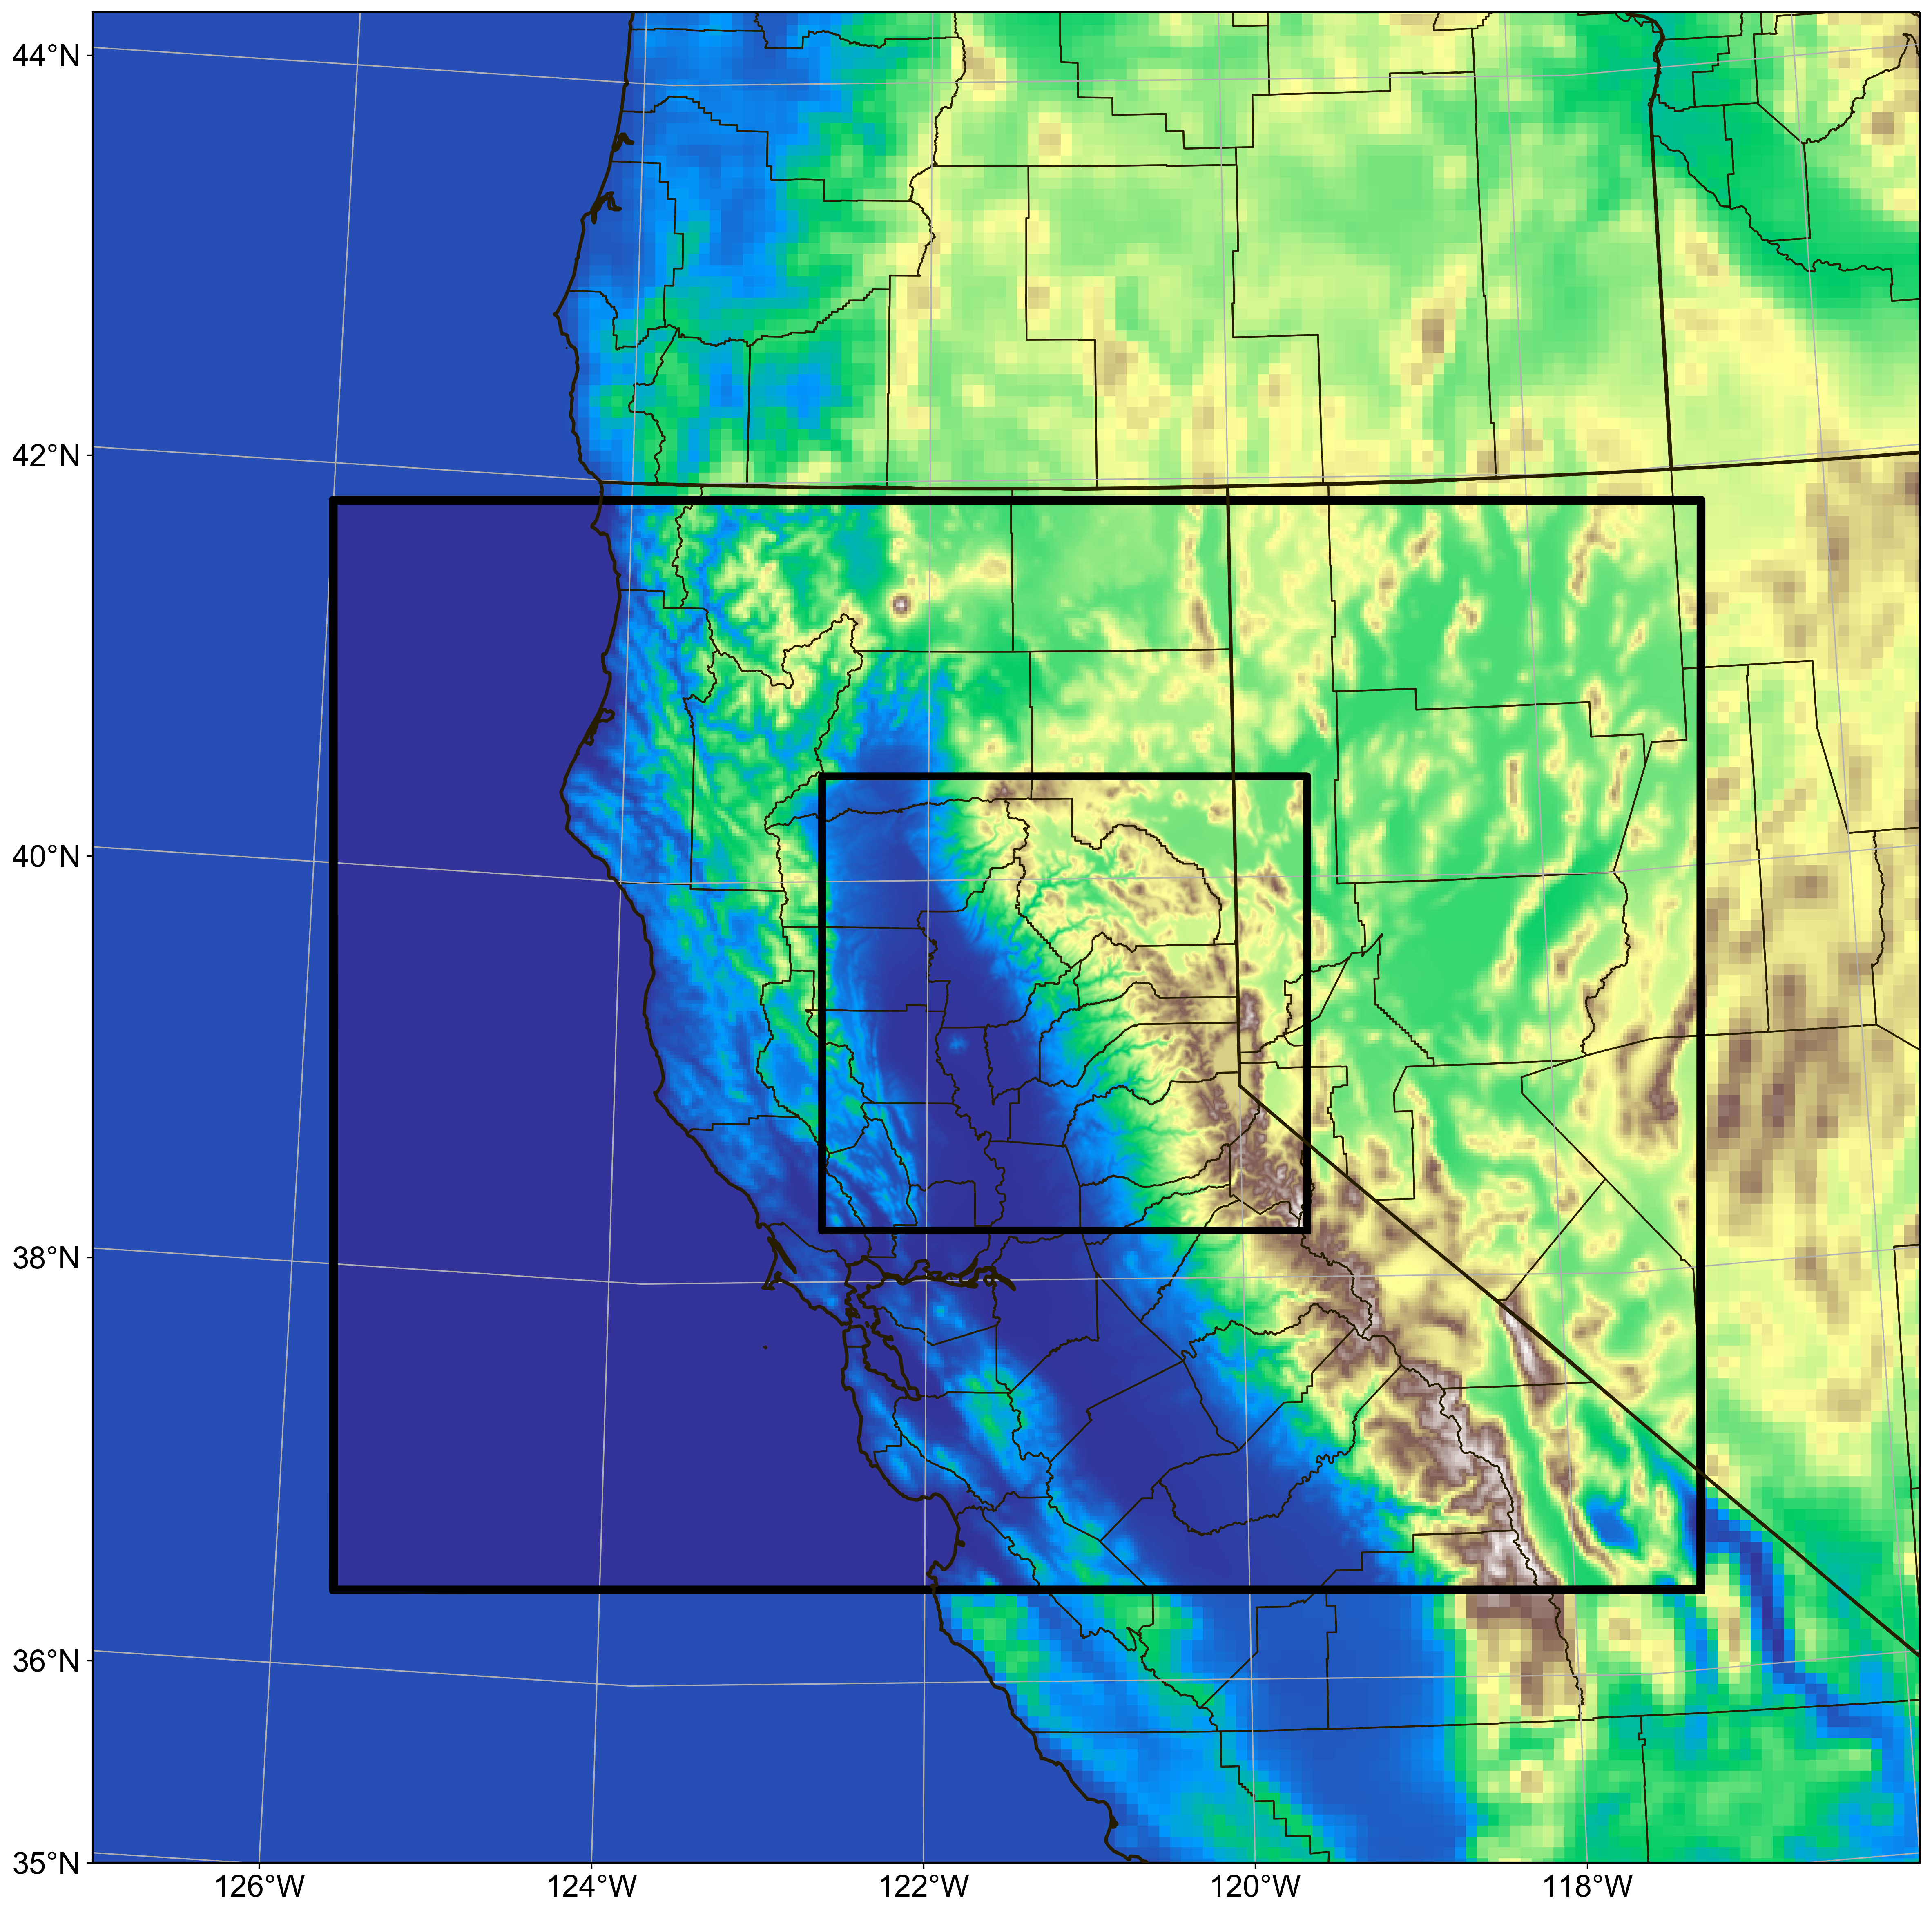

In [4]:
fig, ax = plt.subplots(figsize = (30,20),subplot_kw={'projection': cart_proj}, dpi = 300)
ax.set_extent([-116.+360.,-127.+360., 35, 44.25], crs=ccrs.PlateCarree())
plot_background(ax)
plt.pcolormesh(lon1,lat1,ds1.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
plt.pcolormesh(lon2,lat2,ds2.HGT_M.squeeze(), transform=ccrs.PlateCarree(),cmap = 'terrain')
plt.pcolormesh(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(), cmap = 'terrain')
fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-130,-128,-126,-124,-122,-120,-118,-116,-110, -50, -40, -30, -20, -11, 0, 10, 20, 30, 40, 50]
yticks = [10, 15, 20, 25, 30, 35,36,38, 40,42, 44, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.plot(ds2.corner_lons, ds2.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)
ax.plot(ds3.corner_lons, ds3.corner_lats, transform = ccrs.PlateCarree(), color = 'k', linewidth = 4)

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
ax.text(-127.2,44,'D1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)    
ax.text(-125.55,41.65,'D2', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)
ax.text(-122.2,40.35,'D3', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)
ax.plot([ -121.072881,-122.107479,], [ 40.153468,39.344559,], color='black',linewidth = 4, marker = 'd',markersize = 10, transform=ccrs.PlateCarree(),  path_effects = buffer)
ax.text(-121.65, 39.5, 'Cross Section', horizontalalignment='center',rotation = 45, transform = ccrs.PlateCarree(), color = 'k', fontsize = 12, fontweight = 'bold', path_effects=buffer)
    #start_point = CoordPair(lat=39.344559, lon=-122.072881)
    #end_point = CoordPair(lat=40.153468, lon=-121.107479)
#plt.savefig('wrf_domains_terrain.png', dpi = 300)

In [ ]:
fig, ax2 = plt.subplots(figsize = (20,20),subplot_kw={'projection': cart_proj})
ax2.set_extent([(ds3.corner_lons.max()-1)+360.,(ds3.corner_lons.min()+.5)+360., (ds3.corner_lats.min()+1.15), ds3.corner_lats.max()-.3], crs=ccrs.PlateCarree())
plot_background(ax)
buffer = [patheffects.withStroke(linewidth=3, foreground="w")]

fname = r'ca_camp_20181109_0000_dd83/ca_camp_20181109_0000_dd83.shp'
camp_fireper_2 = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='red', facecolor = '#75000e', alpha = .4)
ax2.add_feature(camp_fireper_2,label = '2nd Fire Perimeter')
f1 = Patch(facecolor='#75000e', edgecolor='r',
                         label='0000 11/09/18 Perimeter', alpha = .7)

fname = r'ca_camp_20181125_1822_dd83/ca_camp_20181125_1822_dd83.shp'
final = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='#a10010', facecolor = '#42040b', alpha = .4)
ax2.add_feature(final,label = 'Final Perimeter')
ff= Patch(facecolor='#42040b', edgecolor='#a10010',
                         label='Final Perimeter', alpha = .7)

fname = r'tl_2015_06_prisecroads/tl_2015_06_prisecroads.shp'
roads = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='black',facecolor = "None", linewidth = 2, alpha = .6)
ax2.add_feature(roads)


plt.contourf(lon3,lat3,ds3.HGT_M.squeeze(), transform=ccrs.PlateCarree(),levels = np.arange(ds3.HGT_M.min(), ds3.HGT_M.max(), 10), cmap = 'terrain')

raws = ax2.scatter(-120.86,39.636, s=350,  marker = 'X', label = 'RAWS', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-120.86-.025,39.636,'SLEC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.52,40.14, s=350,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.52+.03,40.14,'CBXC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.382,40.109, s=350,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.382+.03,40.109,'HMRC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.635,39.589, s=350,  marker = 'X',  transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.635-.03,39.584,'CICC1', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.488,39.735, s=350,  marker = 'X', transform = ccrs.PlateCarree(), color = '#f20f0f',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.488+.03,39.735,'JBGC1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

pge = ax2.scatter(-121.53,39.911, s=350,  marker = 'o', label = 'PG&E Station', transform = ccrs.PlateCarree(), color = '#0f9ff2',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.53-.03,39.911,'PG131', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.18,40.03, s=350,  marker = 'o',  transform = ccrs.PlateCarree(), color = '#0f9ff2',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.18-.03,40.03,'PG129', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)


ax2.scatter(-121.59,39.77, s=350,  marker = 's',  transform = ccrs.PlateCarree(), color = '#9f05ff',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.59-.03,39.77,'Paradise', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.51,39.798, s=350,  marker = 's',  transform = ccrs.PlateCarree(), color = '#9f05ff',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.51+.03,39.798,'Concow', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)


ld = ax2.scatter(-121.574,39.697, s=350,  marker = 'D', label = 'Lidar Scan Location', transform = ccrs.PlateCarree(), color = '#00cc3a',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.574+.02,39.68,'#1', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)

ax2.scatter(-121.638,39.653, s=350,  marker = 'D',  transform = ccrs.PlateCarree(), color = '#00cc3a',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.638-.02,39.653,'#2', horizontalalignment='right', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)


rad = ax2.scatter(-121.603,39.488, s=350,  marker = 'h', label = 'KBBX Radar', transform = ccrs.PlateCarree(), color = 'white',edgecolor= 'k', zorder = 10, linewidth =2)
ax2.text(-121.603+.02,39.482,'KBBX', horizontalalignment='left', transform = ccrs.PlateCarree(), color = 'k', fontsize = 20, fontweight = 'bold', path_effects=buffer)


ax2.legend((f1,ff,raws,pge,ld,rad), ('0000 11/09 Perimeter', 'Final Fire Perimeter', 'RAWS', 'PG&E Stations', 'Lidar Scan Locations', 'KBBX Radar'), fontsize = 'xx-large',ncol = 3)
scale_bar(ax, ccrs.PlateCarree(), 25)
#ax2.text(-120.7, 40.2,u'\u25B2 \nN ', ha='center', fontsize=30, rotation = 0, transform = ccrs.PlateCarree())
fig.canvas.draw()
# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [-124,-123,-122,-121,-120,-119,-118,-117,-116,]
yticks = [35,36,37,38,39, 40,41,42, 44,]
ax2.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
plt.tight_layout()    
#plt.savefig('station_location_fper.png', dpi = 300)

In [ ]:
cart_proj = ccrs.LambertConformal(central_longitude=-121.6,central_latitude=39.76,
                                  standard_parallels=(35,55))
ds2_clats = (ds2.corner_lats)
ds2_clons = (ds2.corner_lons)
print(ds2_clats.max())
print(ds2_clons.max())